# Assignment 5 (Generative models)

**Submission deadlines:**
- get at least 2 points by Tuesday, 7.05
- remaining points: 28.05

**Points:** Aim to get 12 out of 16 possible points.

**Note:** Below, you can find only two problems. We will announce next problems in the next week.


## Submission instructions
We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

# Problem 1. Introduction to Gaussian distribution (2 points)

**Tasks:**

Consider the Gaussian distribution
$$ p(z) = \mathcal{N}(z; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right), 
 \qquad z \in \mathbb{R}.$$

1. **(0.5pt)** Plot the density function for $\mu=0$ and $\sigma^2 \in \{0.5, 1, 2\}$.
  Implement the function `def gaussian_pdf(z, mu, sigma):` and use it to plot the densities.

  Implement the function `def gaussian_sample(n, mu, sigma):` that generates a sample of size $n$ from the Gaussian distribution
	  and plot the histogram (**empirical density**) of the samples for $\mu=0$ and $\sigma^2=1$. 
  Use `torch.distributions.Normal` to generate a sample of size $n=1000$ from the Gaussian distribution with $\mu=0$ and $\sigma^2=1$.
  Plot the histogram of the samples. Compare the histogram with the one obtained in the previous step.

2. **(0.5pt)** Generalize the Gaussian distribution to the multivariate Gaussian distribution; see the formula below.
  Implement the function `def gaussian_pdf(z, mu, sigma):` for the multivariate Gaussian distribution (with diagonal covariance matrix) 
  and plot the density function for $\mu=[0, 0]$ and $\Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$.
  $$ p(z) = \mathcal{N}(z; \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^k|\Sigma|}} \exp\left(-\frac{1}{2} (z-\mu)^T \Sigma^{-1} (z-\mu)\right), 
 \qquad z \in \mathbb{R}^k.$$

	Also, implement the function `def gaussian_sample(n, mu, sigma):` for the multivariate Gaussian distribution.

3. **(1 pt)** KL divergence between two distributions $p, q$ is defined as
$$ KL(p||q) = \int p(z) \log \frac{p(z)}{q(z)} dz.$$
  
Compute the KL divergence between two Gaussian distributions
$$ p(z) = \mathcal{N}(z; \mu_1, \Sigma_1), \qquad q(z) = \mathcal{N}(z; \mu_2, \Sigma_2).$$
  Implement the function `def kl_divergence_gaussian(mu1, sigma1, mu2, sigma2):` that computes the KL divergence between two multivariate Gaussian distributions.
  Test the function with $\mu_1=[0, 0]$, $\Sigma_1 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$, $\mu_2=[0, 0]$, $\Sigma_2 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$.
  The KL divergence between two identical Gaussian distributions should be zero.


# Problem 2. Variational Autoencoder (3 points)

## Generating 2 Moons dataset

Consider the 2D moons dataset generated in the starter code below.

Train the VAE model on the 2 Moons dataset.

Visualize how the latent space is transformed into data points. 
Train a model with 2D latent space. 
Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

Please use the following probability distributions:    
$$
\begin{split}
p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
\end{split}
$$
where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible?

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?
  
**Hints:**
- Use the reparametrization trick to sample from the Gaussian distribution.
- Represent the variance in the neural network as `torch.nn.Parameter(torch.zeros(...))`.
- Represent the variance in the Gaussian distribution as `torch.exp(log_var)` and not as `torch.sqrt(var)`. 
  This trick allows to learn the variance, which must be positive, in a more stable way.

# Starter code

In [15]:
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cuda" if torch.cuda.is_available() else "cpu"

## Moon dataset

In [16]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [17]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

/var/folders/95/wgg4rgc55514swrrztldsyb40000gn/T/ipykernel_62304/1790576989.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = [torch.tensor(tensor) for tensor in tensors]


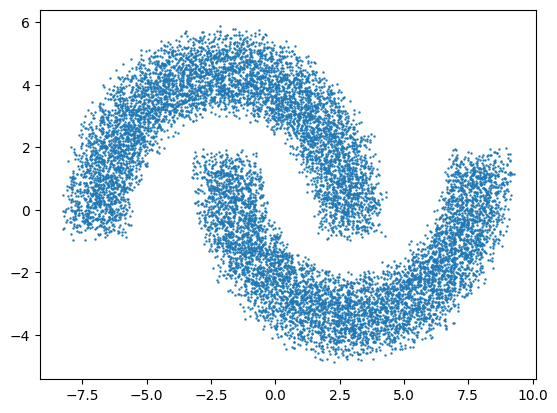

In [18]:
moons = generate_moons(width=1.0)

moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

In [20]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            # TODO: Implement the encoder network as a fully connected neural network.
            #       There are several ways to implement the encoder.
            #       One can use nn.Sequential and output single vector of dimension 2*z_dim,
            #       which represents the parameters of the Gaussian distribution: z_mu, z_log_var.
            # 
            #       Hint: Use ReLU activation function.
            # nn.Linear(    , ),
            # nn.ReLU(),
            # nn.Linear(   , ),
            # nn.ReLU(),
            # nn.Linear(  , 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            # TODO: Implement the decoder network as a fully connected neural network.
            #       Similarly to the encoder, create a fully connected neural network
            #       with three linear layers. 
            #       Output only the x_mu \in R^{in_dim}, since we model x_log_var 
            #       as extra parameter below.
        )

        # Implement the log_var as a parameter.
        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the reparametrization trick.
        
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        
        # Implement the reparametrization trick --> sample z from the Gaussian distribution.
        # sampled_z = TODO
        # return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [21]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    # return TODO
    

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    """Compute KL divergence between two Gaussian distributions."""
    # return TODO


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    # return TODO


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).

    """
    # return TODO

In [ ]:
## Training the VAE

hid_dim = 64
z_dim = 2
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

```
Epoch: 0 loss: 15.3017 recon_loss: 15.0352 kl_loss: 0.2665 avg mean: -0.0953 avg std: 1.0014
Epoch: 200 loss: 4.9773 recon_loss: 2.7884 kl_loss: 2.1889 avg mean: -0.0305 avg std: 0.3532
Epoch: 400 loss: 4.9074 recon_loss: 2.7315 kl_loss: 2.1758 avg mean: -0.0215 avg std: 0.3687
Epoch: 600 loss: 4.8669 recon_loss: 2.6247 kl_loss: 2.2422 avg mean: -0.0549 avg std: 0.3756
Epoch: 800 loss: 4.8175 recon_loss: 2.4267 kl_loss: 2.3908 avg mean: 0.0281 avg std: 0.3628
Epoch: 1000 loss: 4.7753 recon_loss: 2.2255 kl_loss: 2.5498 avg mean: -0.0461 avg std: 0.3532
```

Monitor the loss and the generated data.
Stop when the loss converges and data generation is satisfactory.

Epoch: 0 loss: 15.3017 recon_loss: 15.0352 kl_loss: 0.2665 avg mean: -0.0953 avg std: 1.0014


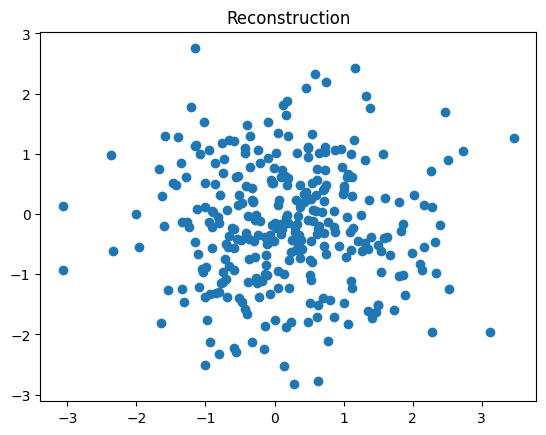

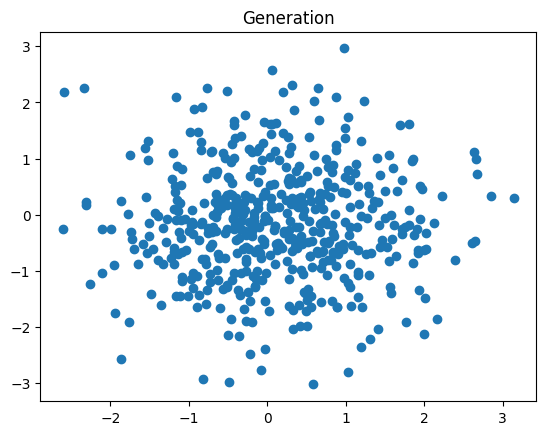

Epoch: 200 loss: 4.9773 recon_loss: 2.7884 kl_loss: 2.1889 avg mean: -0.0305 avg std: 0.3532


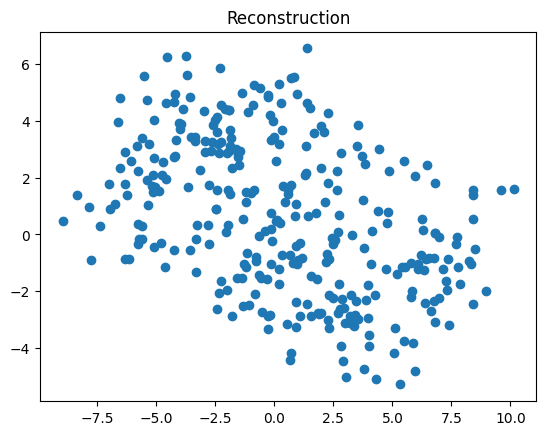

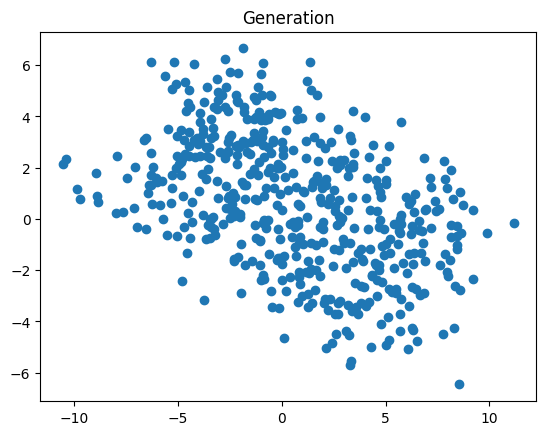

Epoch: 400 loss: 4.9074 recon_loss: 2.7315 kl_loss: 2.1758 avg mean: -0.0215 avg std: 0.3687


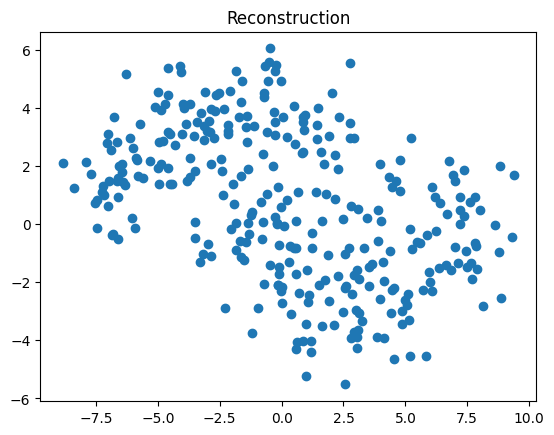

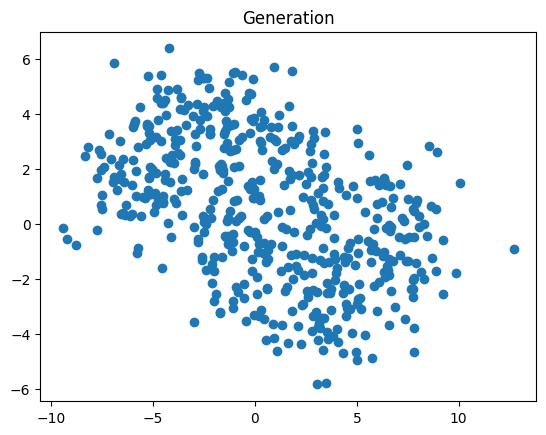

Epoch: 600 loss: 4.8669 recon_loss: 2.6247 kl_loss: 2.2422 avg mean: -0.0549 avg std: 0.3756


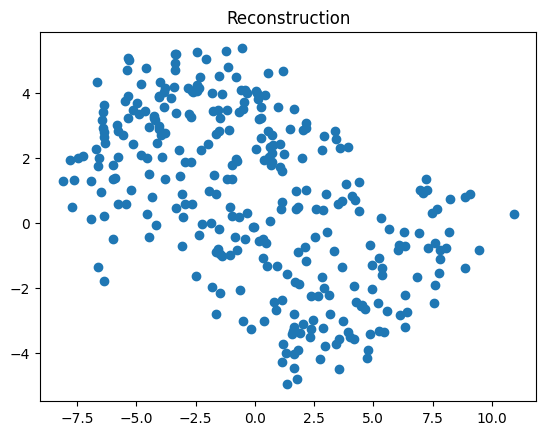

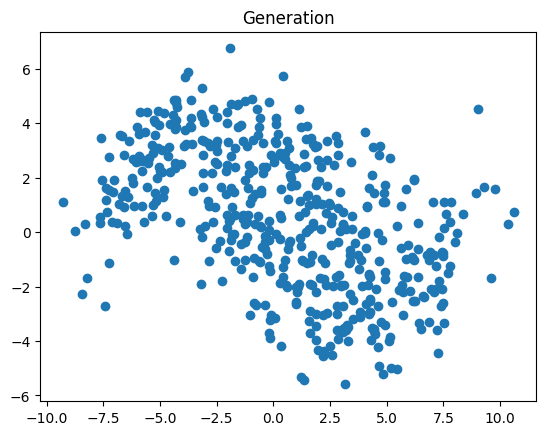

Epoch: 800 loss: 4.8175 recon_loss: 2.4267 kl_loss: 2.3908 avg mean: 0.0281 avg std: 0.3628


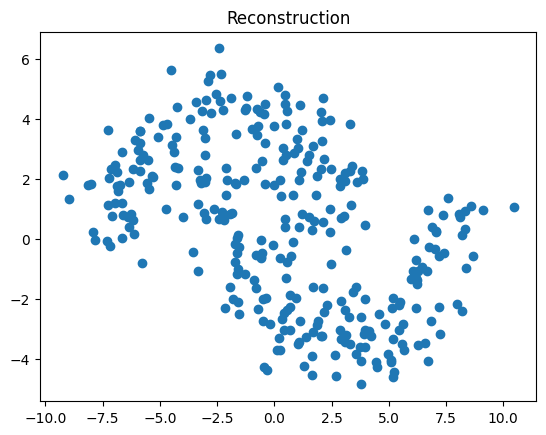

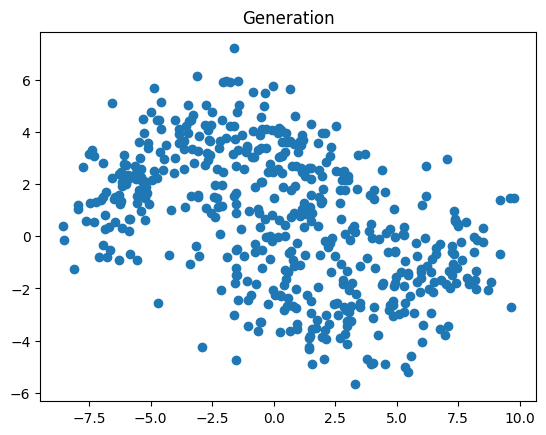

Epoch: 1000 loss: 4.7753 recon_loss: 2.2255 kl_loss: 2.5498 avg mean: -0.0461 avg std: 0.3532


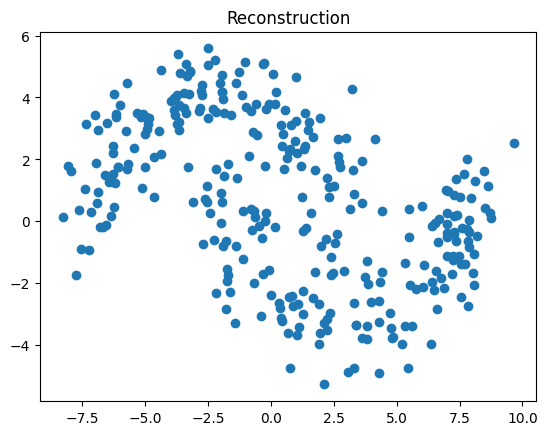

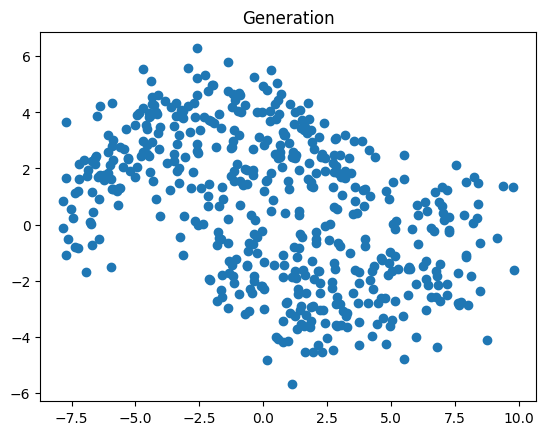

Epoch: 1200 loss: 4.7335 recon_loss: 2.0294 kl_loss: 2.7042 avg mean: -0.0087 avg std: 0.3302


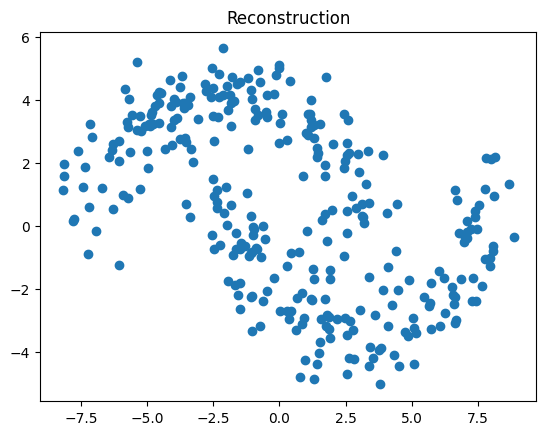

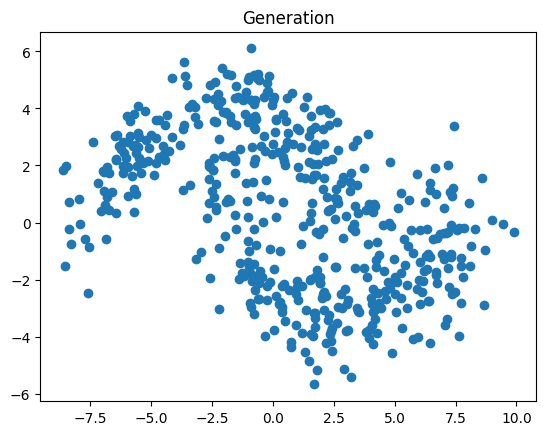

Epoch: 1400 loss: 4.7397 recon_loss: 1.8561 kl_loss: 2.8836 avg mean: -0.0259 avg std: 0.3086


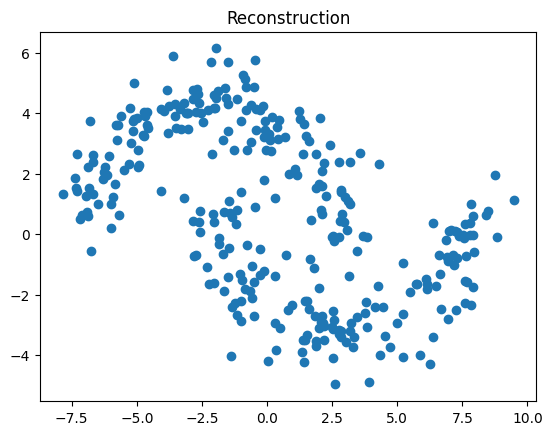

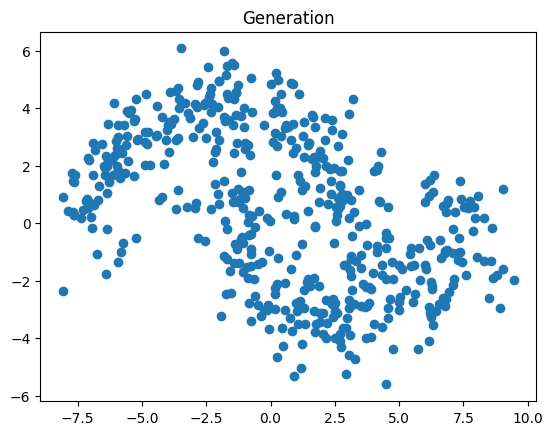

Epoch: 1600 loss: 4.7082 recon_loss: 1.7053 kl_loss: 3.0029 avg mean: 0.0074 avg std: 0.2880


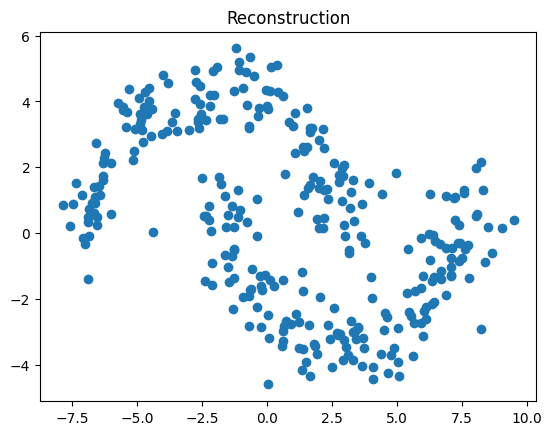

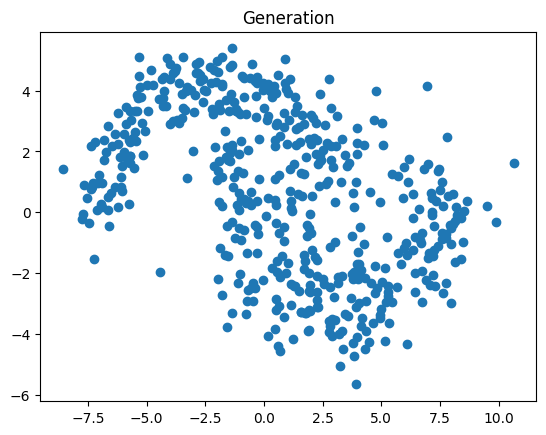

Epoch: 1800 loss: 4.6890 recon_loss: 1.6177 kl_loss: 3.0713 avg mean: 0.0261 avg std: 0.2862


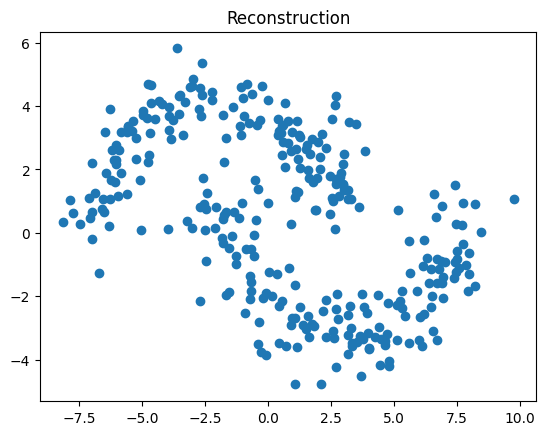

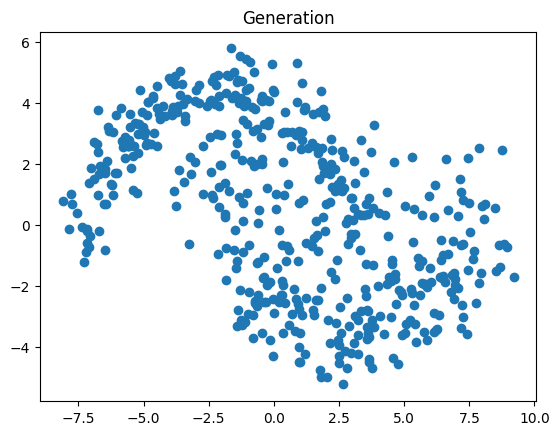

Epoch: 2000 loss: 4.6802 recon_loss: 1.5206 kl_loss: 3.1596 avg mean: -0.0240 avg std: 0.2797


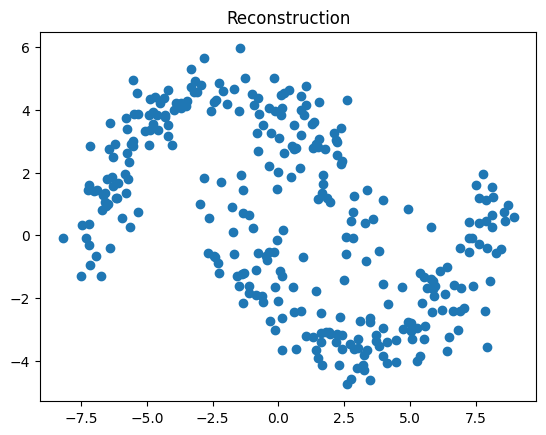

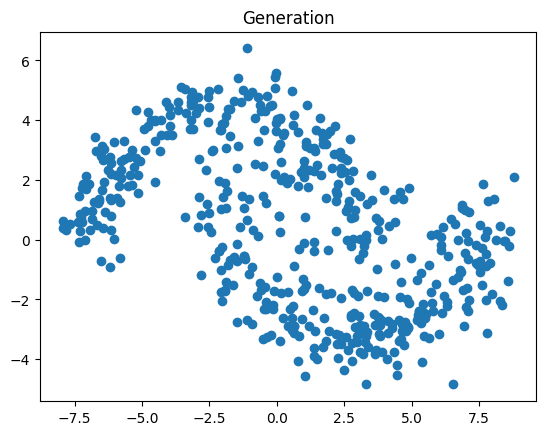

Epoch: 2200 loss: 4.6741 recon_loss: 1.3867 kl_loss: 3.2874 avg mean: 0.0044 avg std: 0.2639


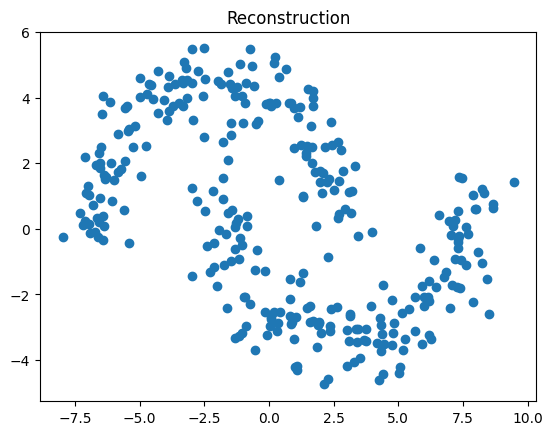

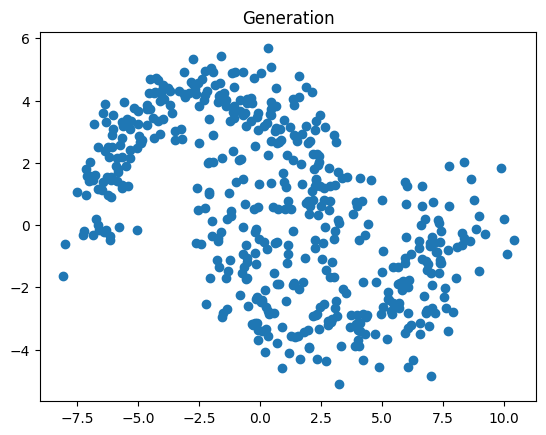

Epoch: 2400 loss: 4.6675 recon_loss: 1.1613 kl_loss: 3.5062 avg mean: -0.0680 avg std: 0.2418


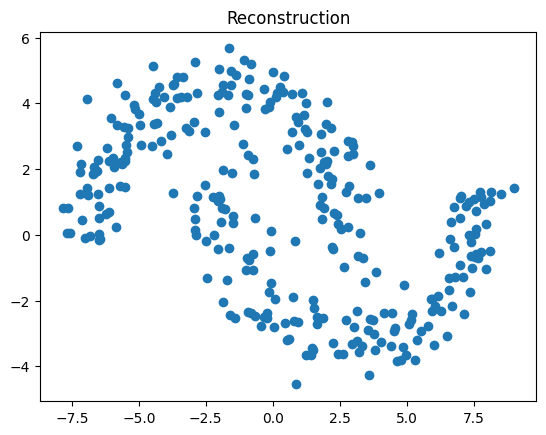

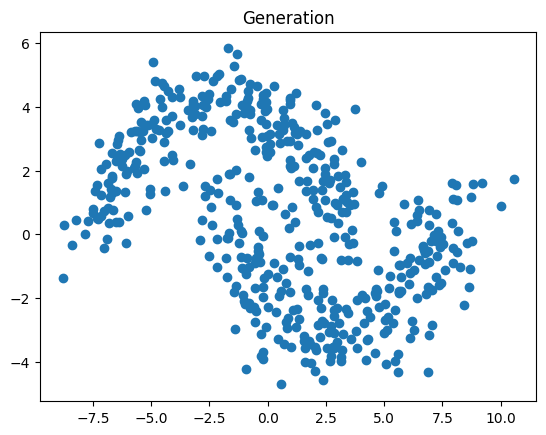

Epoch: 2600 loss: 4.6310 recon_loss: 0.9851 kl_loss: 3.6459 avg mean: 0.0136 avg std: 0.2158


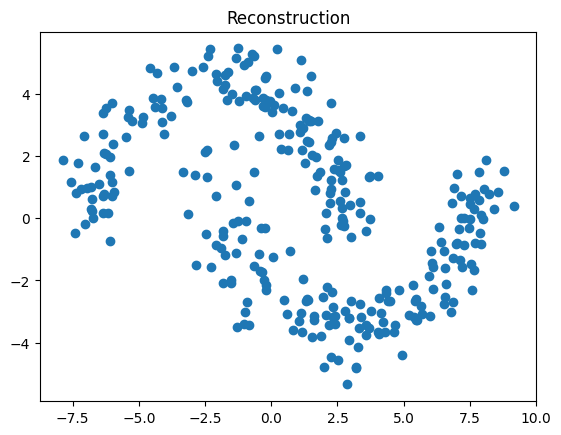

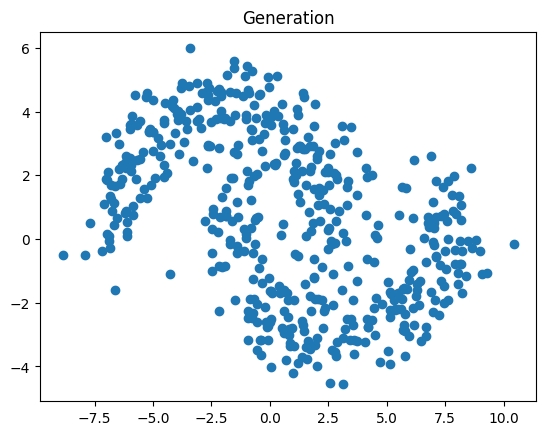

Epoch: 2800 loss: 4.6225 recon_loss: 0.8828 kl_loss: 3.7398 avg mean: 0.0221 avg std: 0.2131


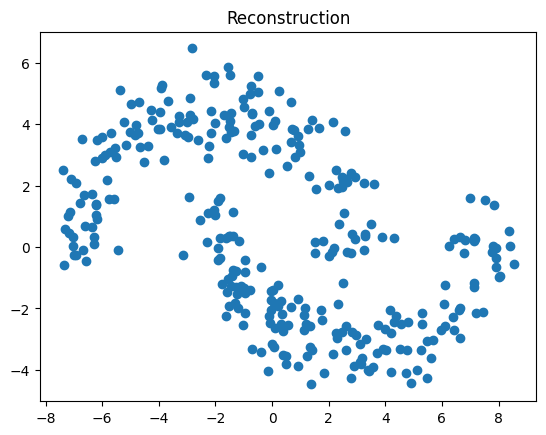

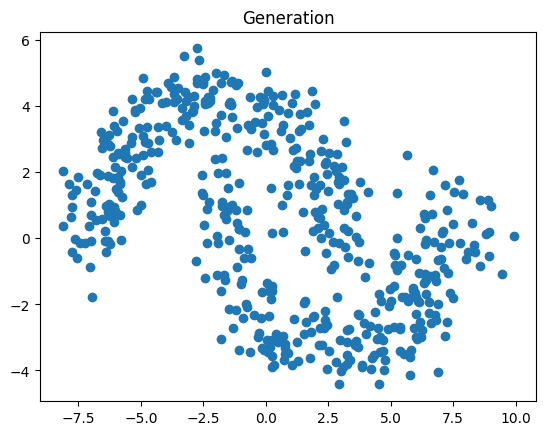

Epoch: 3000 loss: 4.6176 recon_loss: 0.7322 kl_loss: 3.8854 avg mean: 0.0118 avg std: 0.1951


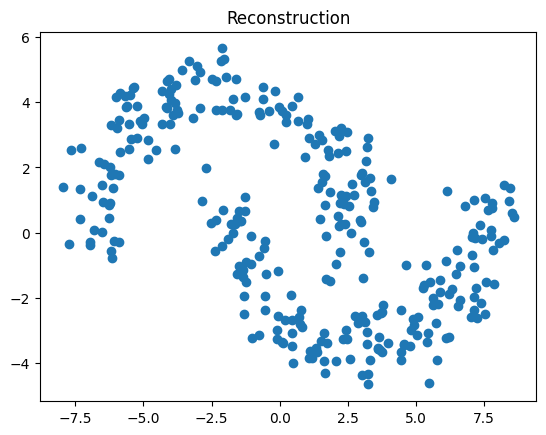

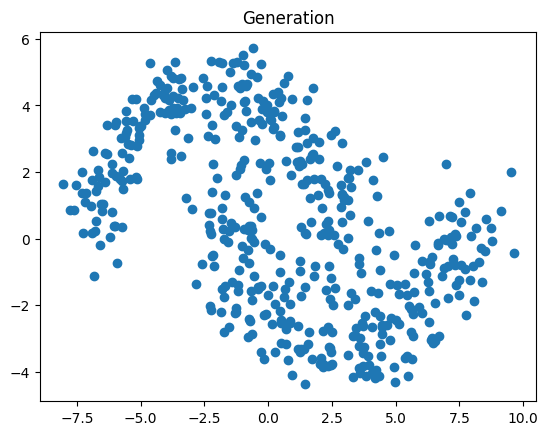

Epoch: 3200 loss: 4.6123 recon_loss: 0.6043 kl_loss: 4.0080 avg mean: 0.0477 avg std: 0.1794


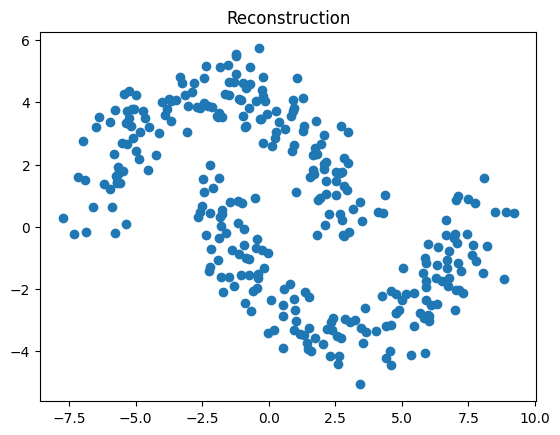

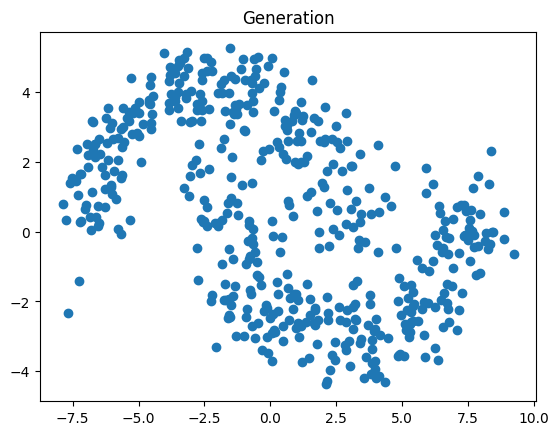

Epoch: 3400 loss: 4.5905 recon_loss: 0.5008 kl_loss: 4.0897 avg mean: -0.0415 avg std: 0.1819


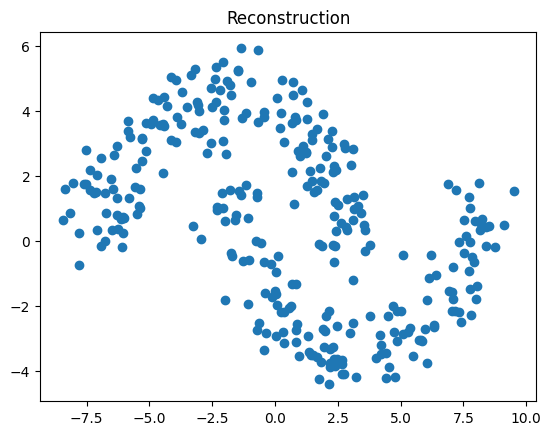

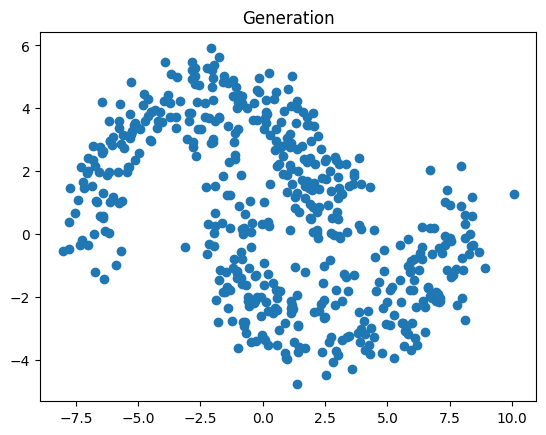

Epoch: 3600 loss: 4.5905 recon_loss: 0.4099 kl_loss: 4.1806 avg mean: 0.0152 avg std: 0.1741


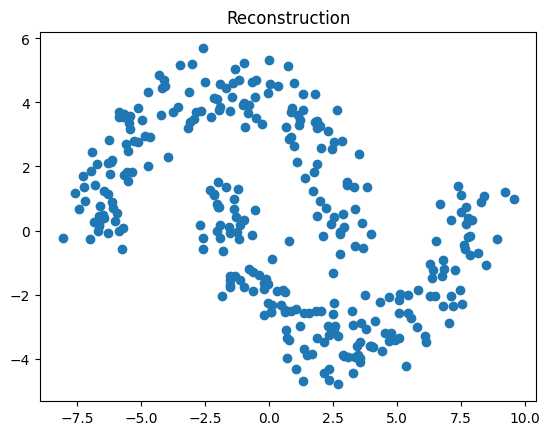

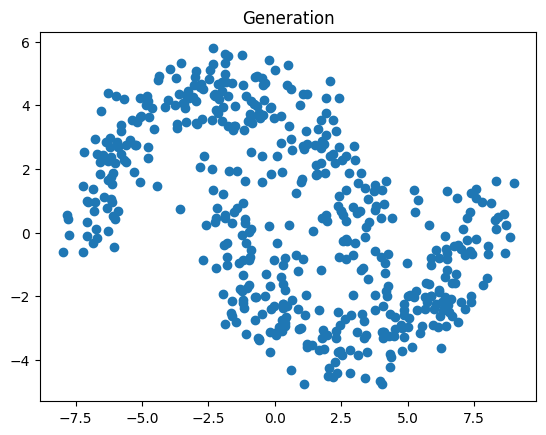

Epoch: 3800 loss: 4.6165 recon_loss: 0.3533 kl_loss: 4.2632 avg mean: 0.0590 avg std: 0.1596


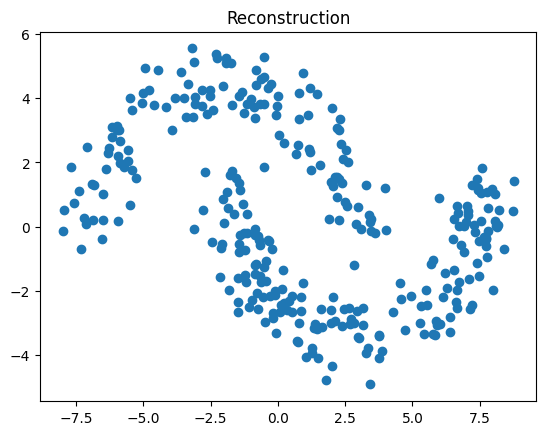

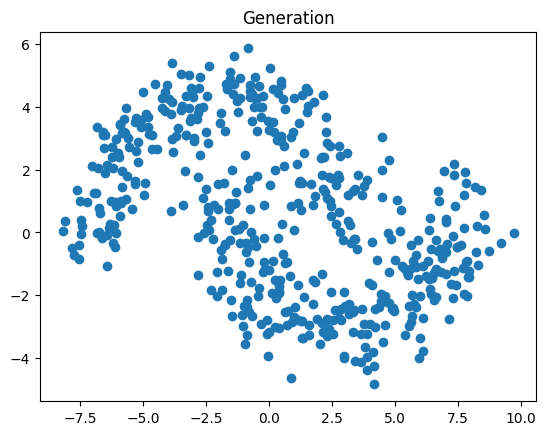

Epoch: 4000 loss: 4.5812 recon_loss: 0.2777 kl_loss: 4.3036 avg mean: 0.0448 avg std: 0.1659


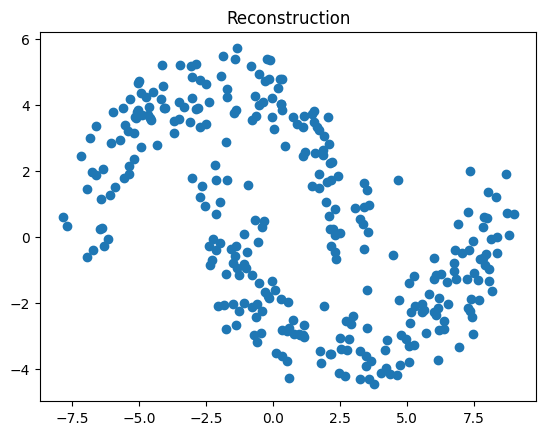

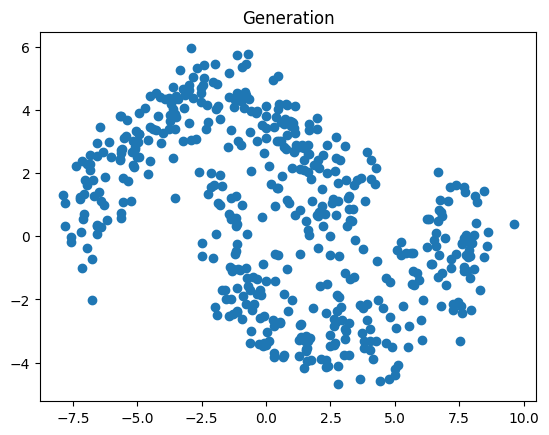

Epoch: 4200 loss: 4.5844 recon_loss: 0.2521 kl_loss: 4.3323 avg mean: -0.0464 avg std: 0.1623


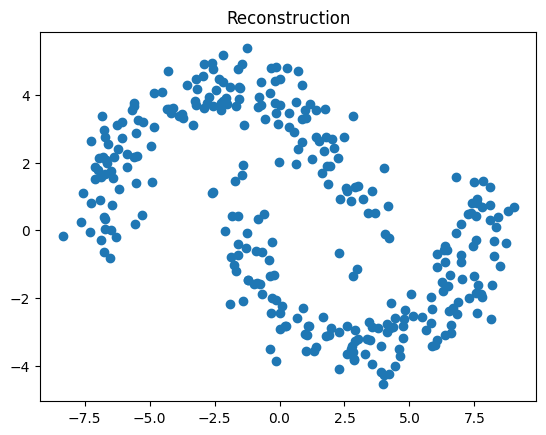

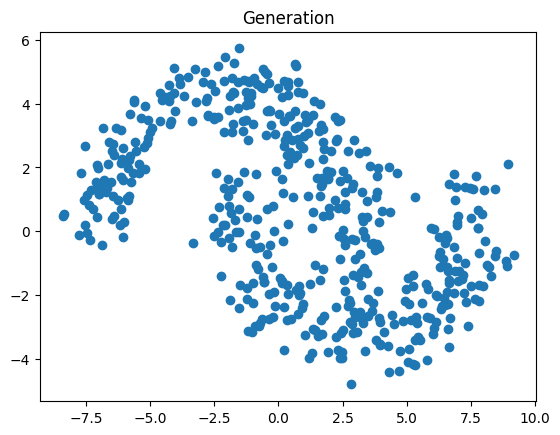

Epoch: 4400 loss: 4.5797 recon_loss: 0.1541 kl_loss: 4.4256 avg mean: 0.0203 avg std: 0.1580


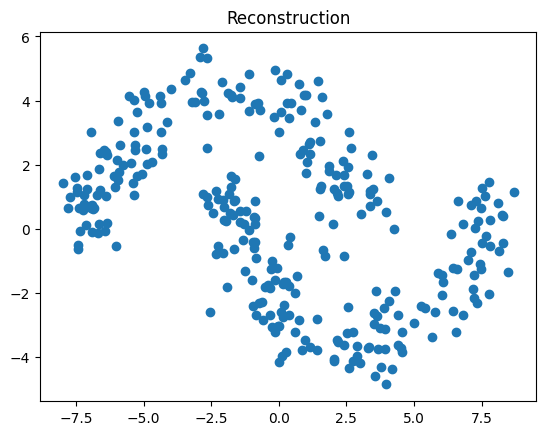

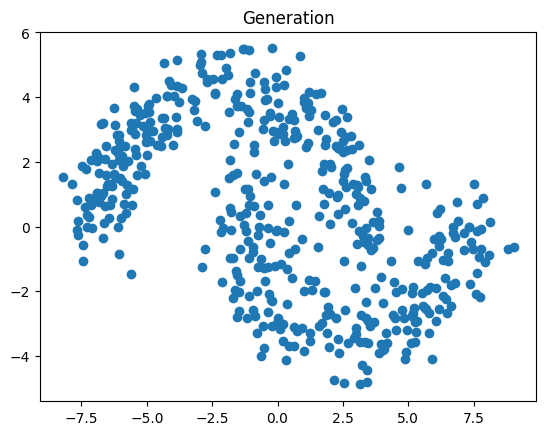

Epoch: 4600 loss: 4.5787 recon_loss: 0.1780 kl_loss: 4.4007 avg mean: -0.0187 avg std: 0.1570


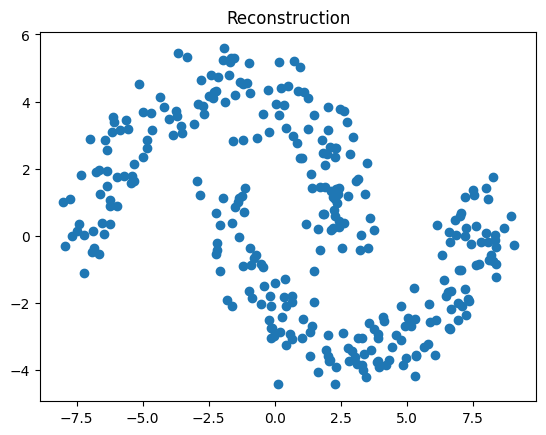

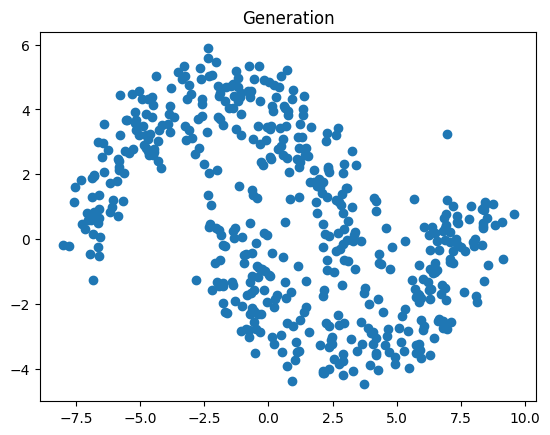

Epoch: 4800 loss: 4.5878 recon_loss: 0.1263 kl_loss: 4.4615 avg mean: 0.0063 avg std: 0.1558


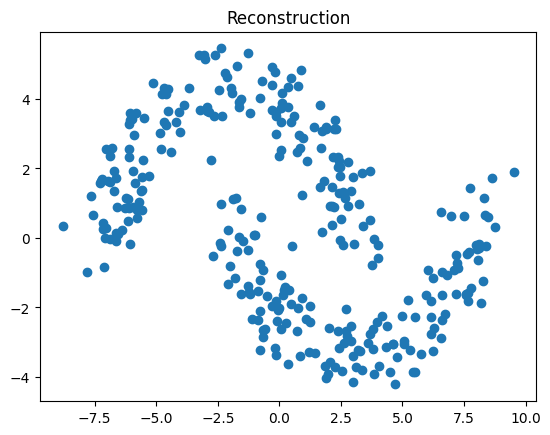

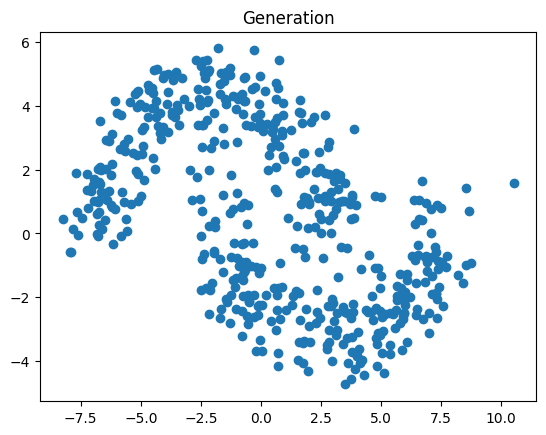

Epoch: 5000 loss: 4.5700 recon_loss: 0.0824 kl_loss: 4.4876 avg mean: 0.0423 avg std: 0.1453


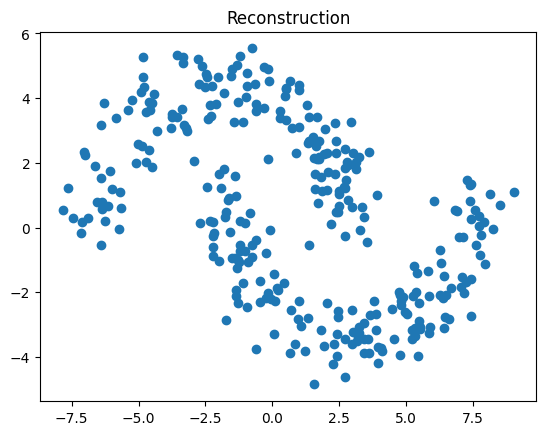

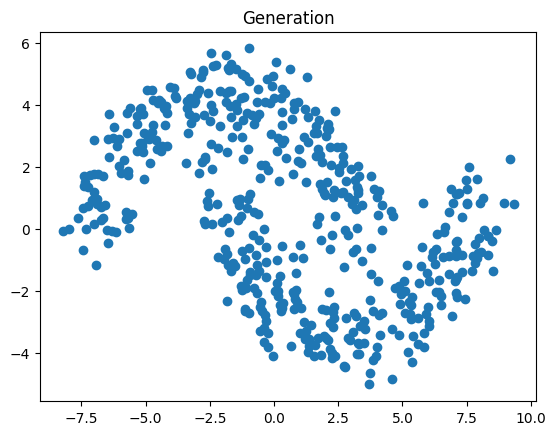

Epoch: 5200 loss: 4.5743 recon_loss: 0.0778 kl_loss: 4.4965 avg mean: -0.0380 avg std: 0.1538


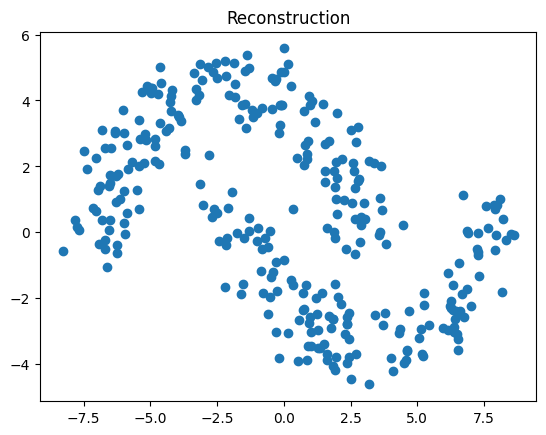

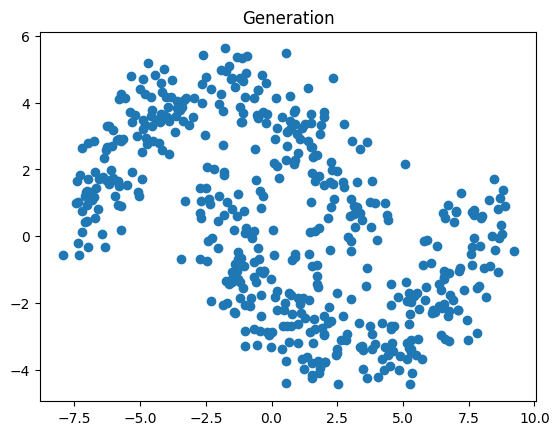

Epoch: 5400 loss: 4.5810 recon_loss: 0.0353 kl_loss: 4.5457 avg mean: 0.0011 avg std: 0.1452


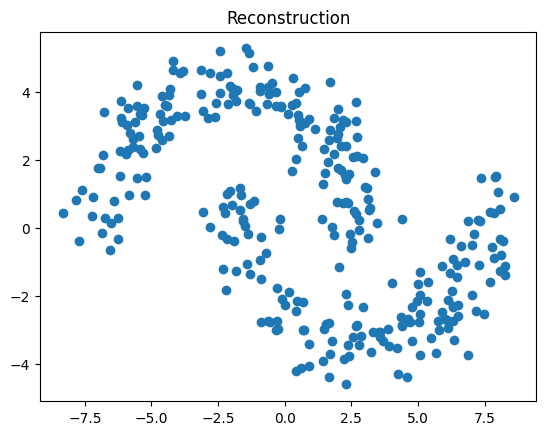

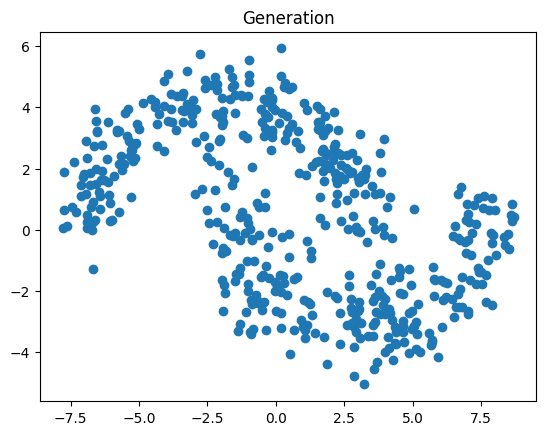

Epoch: 5600 loss: 4.5575 recon_loss: 0.0233 kl_loss: 4.5343 avg mean: -0.0045 avg std: 0.1526


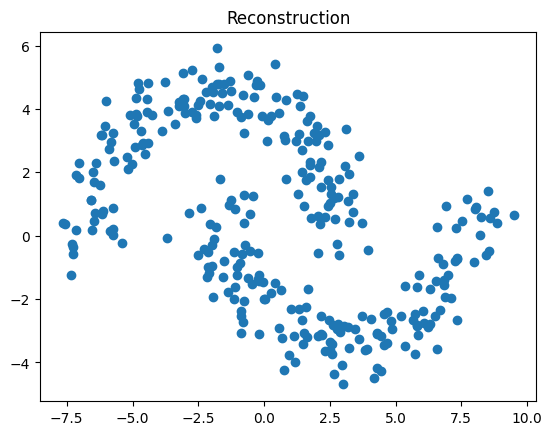

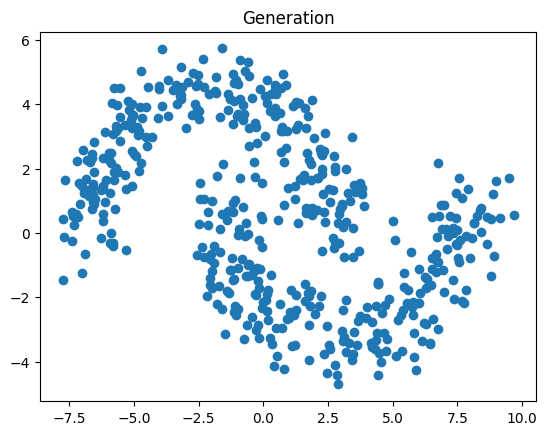

Epoch: 5800 loss: 4.5675 recon_loss: 0.0257 kl_loss: 4.5418 avg mean: 0.0231 avg std: 0.1541


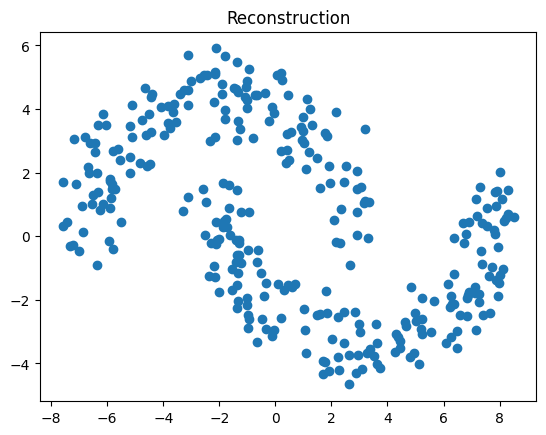

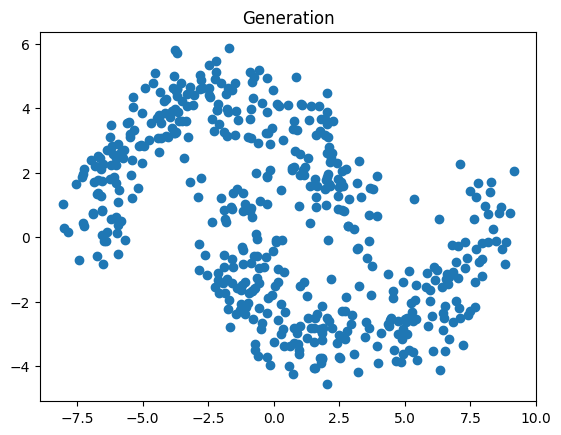

Epoch: 6000 loss: 4.5619 recon_loss: -0.0332 kl_loss: 4.5950 avg mean: 0.0176 avg std: 0.1440


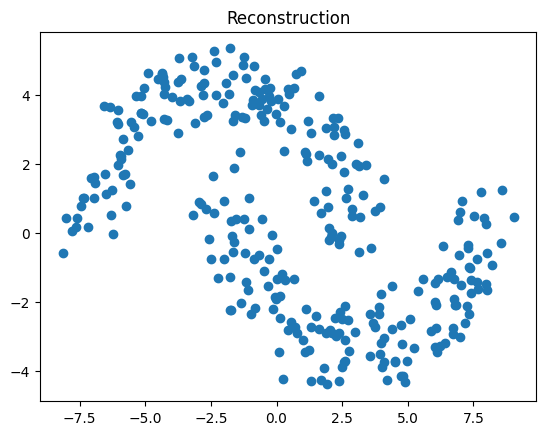

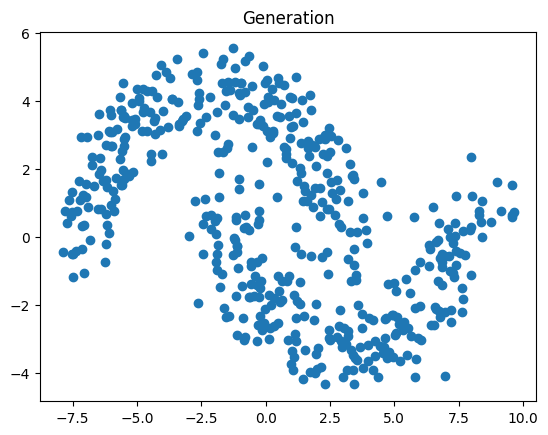

Epoch: 6200 loss: 4.5592 recon_loss: -0.0122 kl_loss: 4.5714 avg mean: -0.0135 avg std: 0.1454


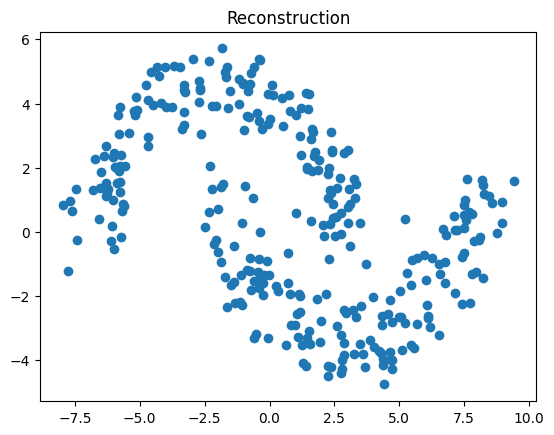

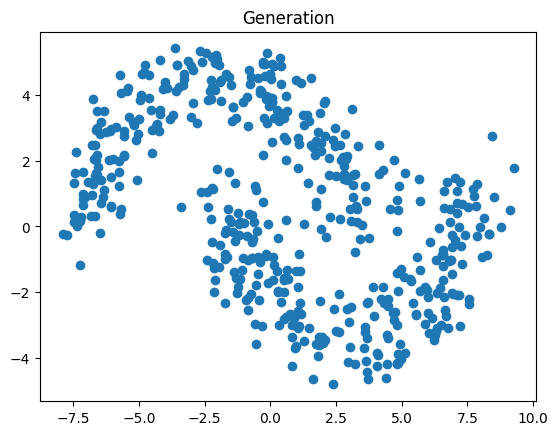

Epoch: 6400 loss: 4.5583 recon_loss: -0.0142 kl_loss: 4.5725 avg mean: 0.0374 avg std: 0.1473


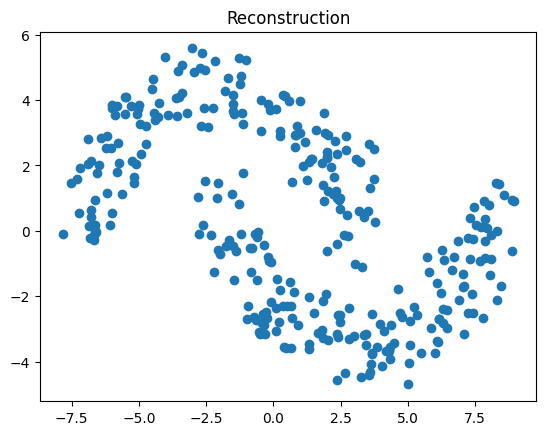

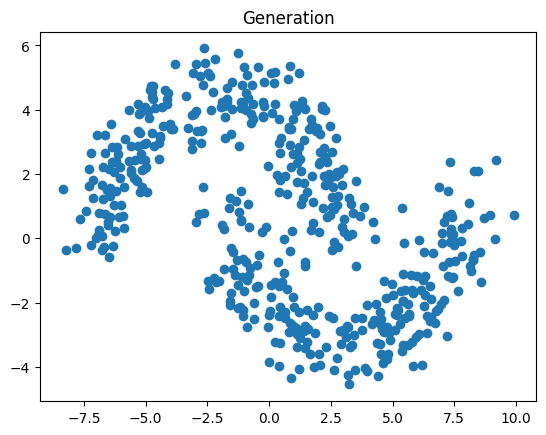

Epoch: 6600 loss: 4.5733 recon_loss: -0.0688 kl_loss: 4.6421 avg mean: 0.0481 avg std: 0.1425


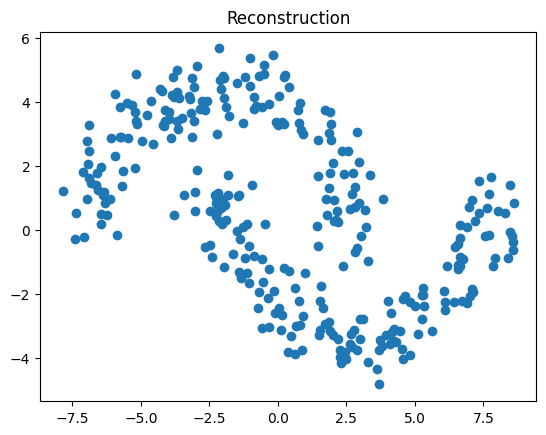

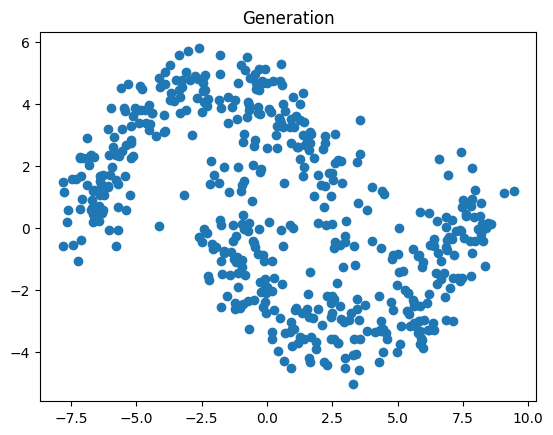

Epoch: 6800 loss: 4.5640 recon_loss: -0.0540 kl_loss: 4.6180 avg mean: 0.0471 avg std: 0.1463


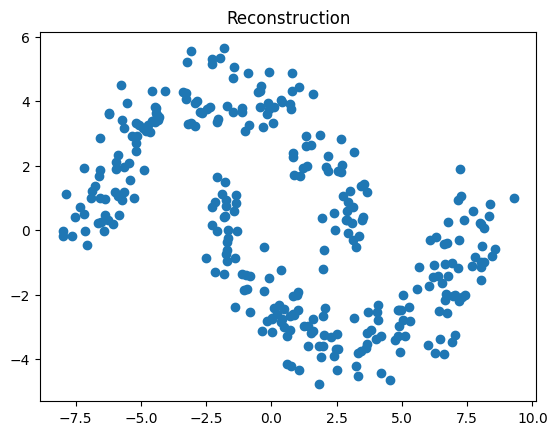

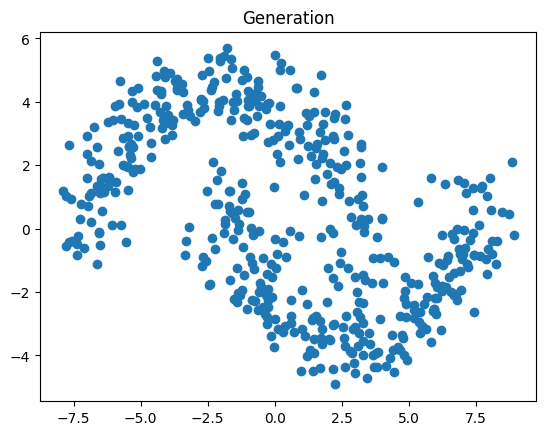

Epoch: 7000 loss: 4.5657 recon_loss: -0.0628 kl_loss: 4.6285 avg mean: 0.0516 avg std: 0.1452


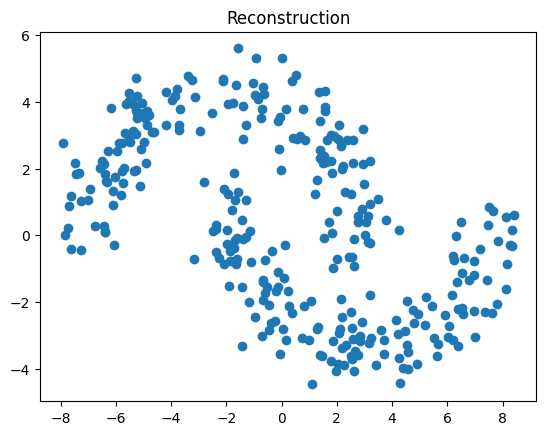

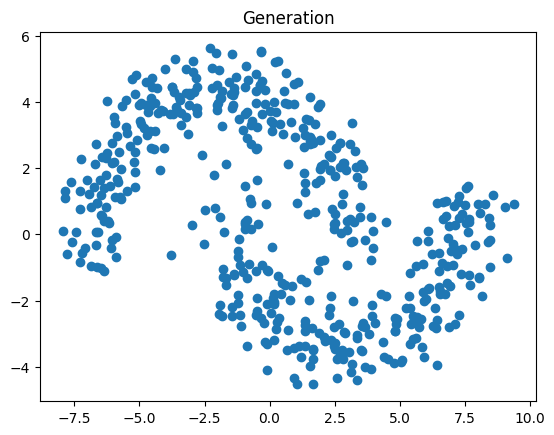

Epoch: 7200 loss: 4.5774 recon_loss: -0.0650 kl_loss: 4.6425 avg mean: -0.0148 avg std: 0.1472


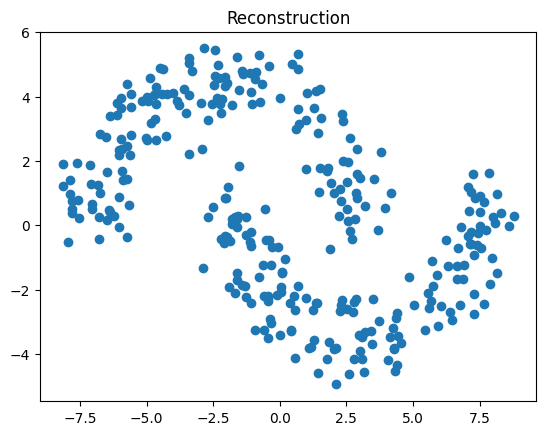

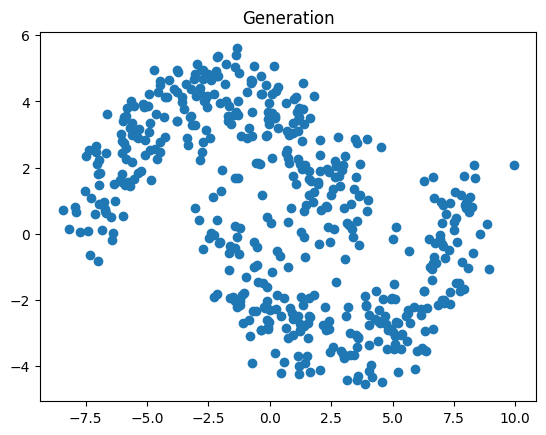

Epoch: 7400 loss: 4.5509 recon_loss: -0.0996 kl_loss: 4.6504 avg mean: -0.0325 avg std: 0.1507


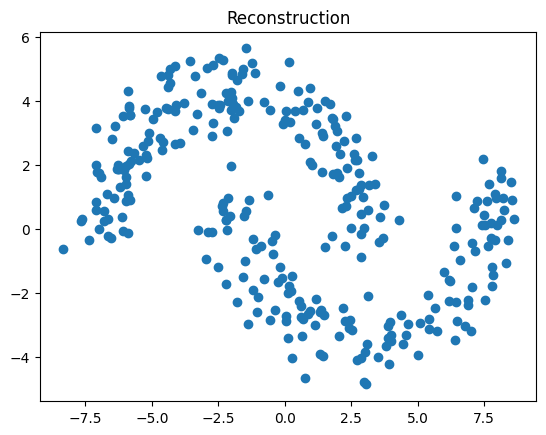

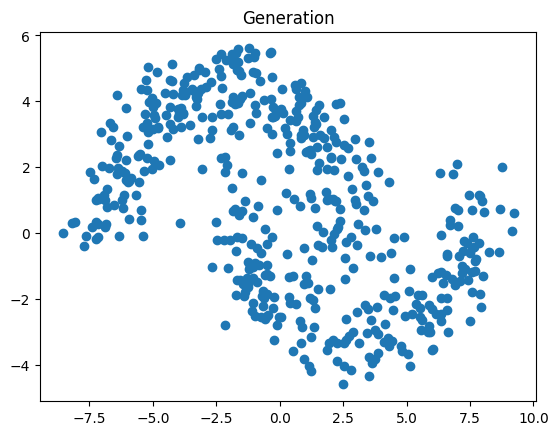

In [8]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

In [9]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

Text(0.5, 1.0, 'Data in latent space')

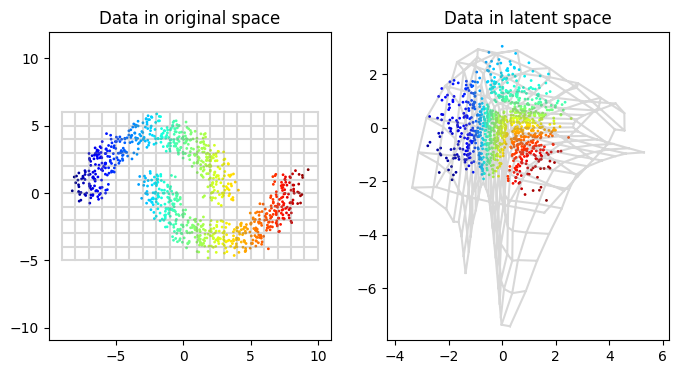

In [12]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
# enc_grid = TODO
# enc_data = TODO

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

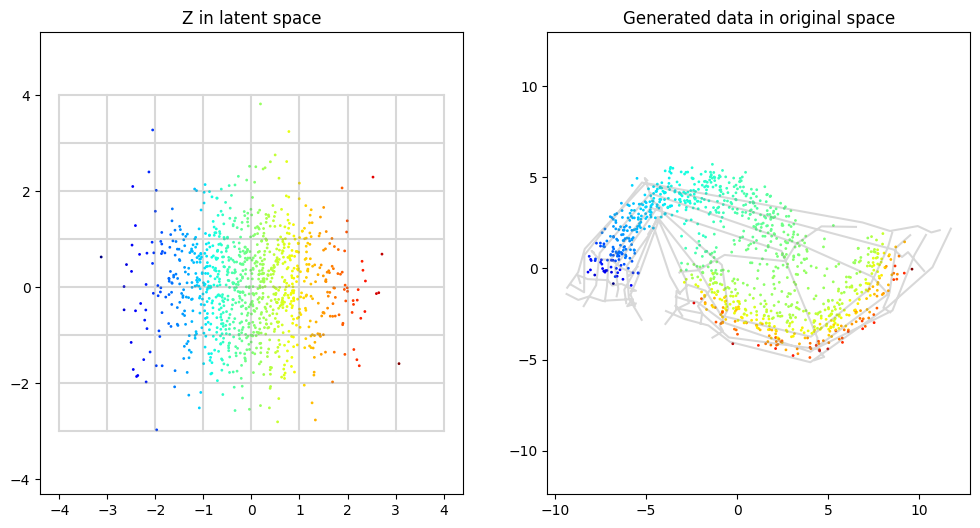

In [13]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid
# x_gen = TODO
# grid_gen = TODO

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")